In [2]:
import pymongo as pm #import MongoClient only
from pymongo import MongoClient
import pprint # prettyprinting for json objects
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#Database connexion
client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use


# Step 2 -  Car sharing usage 

## Question 1

In [3]:
#Some practical implementations

# Collections
bookings_collection = db['PermanentBookings']
parkings_collection = db['PermanentParkings']

# Define date range for querying
start_date = datetime(2017, 11, 1)
end_date = datetime(2018, 1, 31, 23, 59, 59)

# Define the cities to analyze
cities = ["Madrid", "Denver", "Austin"]



### Code

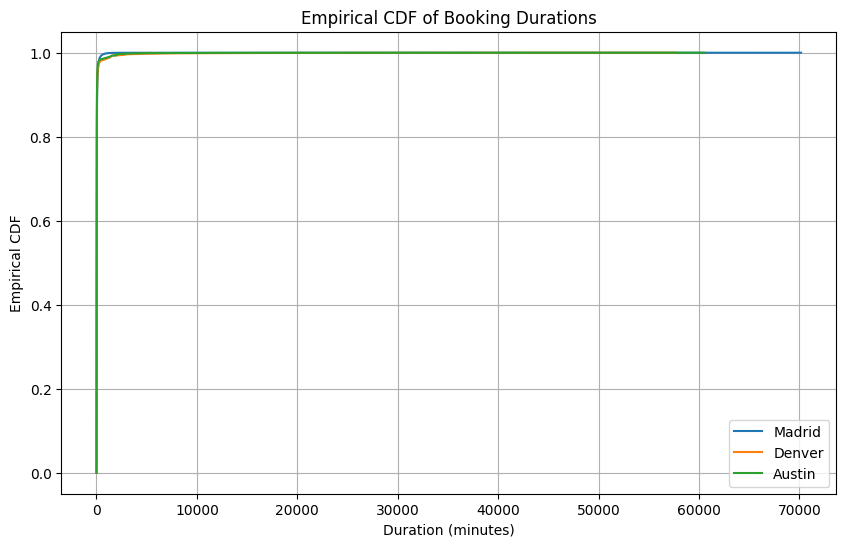

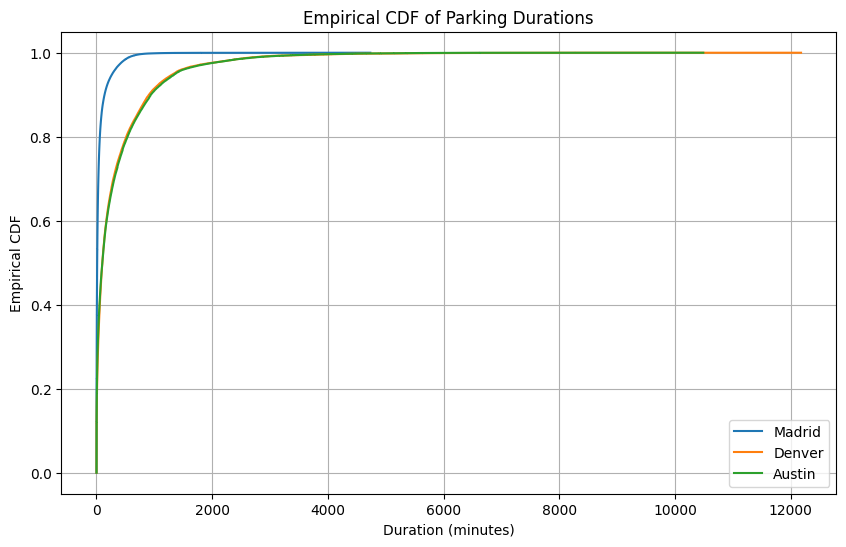

In [4]:
# Function to retrieve and process data for bookings or parkings
def get_durations(collection, city):
    # Query to filter by city and date range
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lte': end_date},
        'final_date': {'$exists': True}  # Ensure final_date exists
    }
    # Fields to retrieve
    projection = {
        '_id': 0,
        'init_date': 1,
        'final_date': 1
    }
    # Retrieve data
    data = list(collection.find(query, projection))
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Ensure dates are datetime objects
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])
    # Compute duration in minutes
    df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
    # Filter out any negative or zero durations (if any)
    df = df[df['duration'] > 0]
    return df['duration']

# Initialize dictionaries to hold durations
booking_durations = {}
parking_durations = {}

# Retrieve durations for each city
for city in cities:
    booking_durations[city] = get_durations(bookings_collection, city)
    parking_durations[city] = get_durations(parkings_collection, city)


def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=city)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot CDFs for bookings
plot_cdf(booking_durations, 'Empirical CDF of Booking Durations')

# Plot CDFs for parkings
plot_cdf(parking_durations, 'Empirical CDF of Parking Durations')


### Interpretation

a. Density for Larger Values of Duration

Madrid’s CDF curve rises the quickest and reaches near 1.0 earlier than Denver and Austin, indicating that Madrid has a higher density of shorter parking durations.
Denver and Austin have slower-rising CDFs, which means they tend to have a greater density of larger parking durations compared to Madrid.
Of the three, Austin appears to have the slowest rise in the CDF in the mid-range (around 1000-5000 minutes), suggesting that it has a larger proportion of long-duration parkings.
Is This Expected?

This might be expected if there are city-specific factors influencing parking behavior. For instance, Madrid might have stricter rules or higher turnover in parking spots, encouraging shorter parking times.
Austin's slower rise in the CDF could indicate that users park for longer durations, which could be due to larger or more readily available parking spaces, or user patterns unique to that city.
Outliers:The tail extending to very high values of parking duration (above 8000 minutes) suggests the presence of outliers in the data.
These could represent vehicles left parked for abnormally long periods, possibly due to inactivity or service issues.
The CDFs reaching 1.0 with these extreme durations suggest that these values are rare, but they are still influencing the overall distribution.

b. Differences in the CDFs
Madrid’s Sharp Rise: Madrid’s CDF rises sharply at lower durations, indicating that most parkings are relatively short. This could reflect a high turnover rate, possibly driven by high demand or short-distance usage patterns.
Denver and Austin’s Gradual Increase:
Both Denver and Austin show slower increases in the CDF, particularly Austin. This suggests that a significant portion of parkings in these cities have longer durations.
These differences might be attributed to factors like urban layout, parking policies, and usage habits specific to each city.
Summary Interpretation
Madrid has shorter parking durations, likely due to higher turnover or restrictions.
Austin has the longest parking durations among the three, suggesting either more relaxed parking or different usage patterns.
Outliers in the form of extremely long parking durations exist in all cities and may require further investigation to understand if they represent actual usage or anomalies in the data.

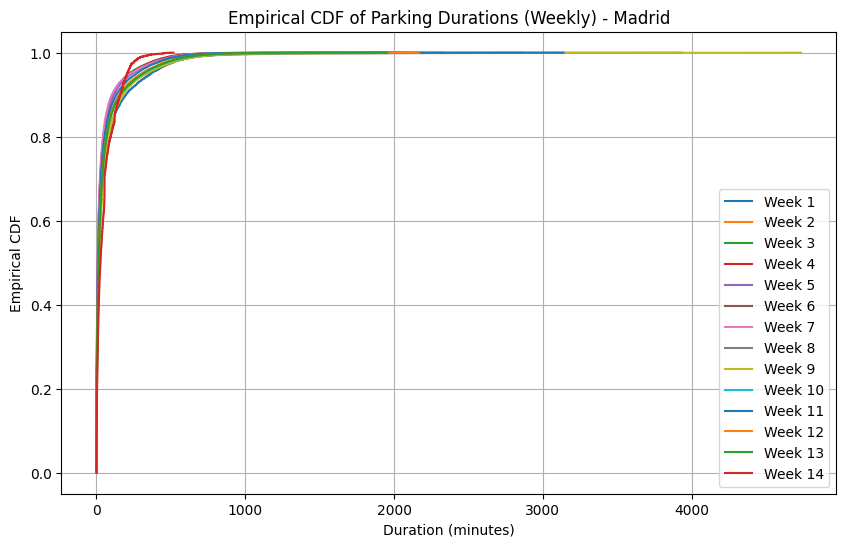

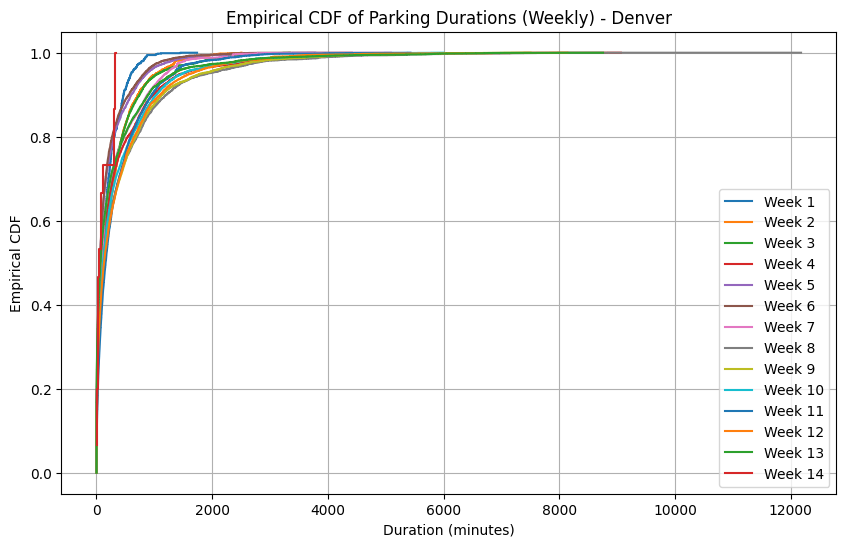

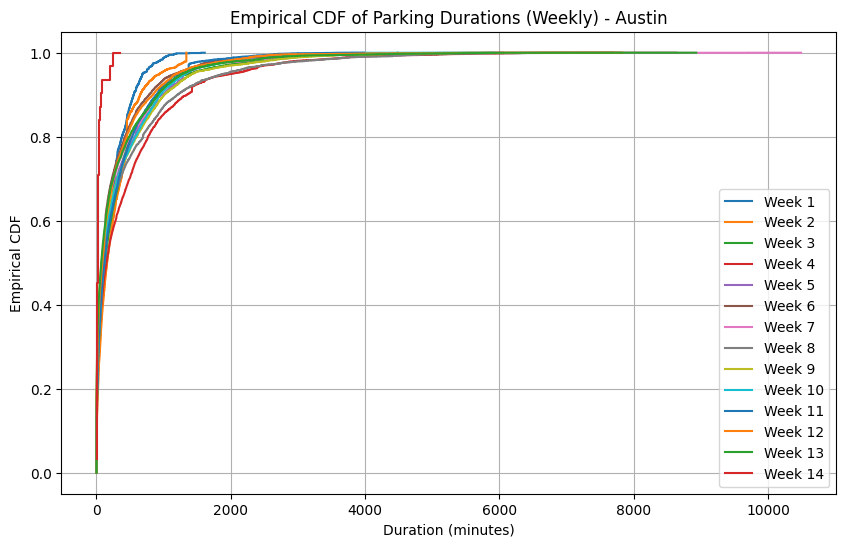

In [13]:
from datetime import timedelta

def get_weekly_durations(collection, city):
    """Retrieve durations by weekly periods for a specific city."""
    weekly_durations = {}
    start_date = datetime(2017, 11, 1)
    end_date = datetime(2018, 1, 31, 23, 59, 59)
    week = 0

    while start_date < end_date:
        week_end = start_date + timedelta(days=7)
        # Query to filter by city and weekly date range
        query = {
            'city': city,
            'init_date': {'$gte': start_date, '$lt': week_end},
            'final_date': {'$exists': True}
        }
        # Retrieve data and compute duration as before
        data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
        df = pd.DataFrame(data)
        if not df.empty:
            df['init_date'] = pd.to_datetime(df['init_date'])
            df['final_date'] = pd.to_datetime(df['final_date'])
            df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
            df = df[df['duration'] > 0]
            weekly_durations[f"Week {week + 1}"] = df['duration']
        start_date = week_end
        week += 1

    return weekly_durations

# Plot weekly CDFs for each city
for city in cities:
    weekly_durations = get_weekly_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for week, durations in weekly_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=week)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(f'Empirical CDF of Parking Durations (Weekly) - {city}')
    plt.legend()
    plt.grid(True)
    plt.show()


Madrid:

The weekly CDFs for Madrid are relatively consistent, with most weeks following a similar distribution for parking durations.
There is a slight variation between some weeks, particularly in the initial rise of the CDF, indicating some fluctuation in short-duration parking usage.
Overall, most weeks in Madrid show a rapid rise in the CDF, suggesting that a high proportion of parking events are of shorter durations. This consistency might imply stable user behavior across weeks.
Denver:

In Denver, there is slightly more variation between weeks than in Madrid, especially for short parking durations (0–1000 minutes).
Some weeks show a slower rise in the CDF, suggesting more parking events of longer durations during those weeks.
This variability could indicate weekly changes in user behavior or external factors affecting parking times, such as local events, weather conditions, or demand fluctuations.
Austin:

The weekly CDFs in Austin show similar characteristics to those in Denver, with some noticeable variability between weeks.
A few weeks (e.g., Week 1 and Week 4) display a sharper initial rise, indicating shorter average parking durations, while other weeks show a slower rise, suggesting more longer-duration parking events.
This variability could be due to similar factors as in Denver, such as weekly events, changes in demand, or varying user patterns.
General Observations Across Cities
Variation in Short-Duration Parkings:

Across all cities, we observe slight weekly differences in the CDF curves, particularly in the initial rise. This suggests that the proportion of short-duration parking events fluctuates from week to week, likely due to changes in demand or usage patterns.
Longer-Duration Parkings:

For all three cities, the CDFs level off near 1.0 at around 3000-4000 minutes, indicating that very long-duration parking events are relatively rare but still present in some weeks.
These longer parkings might represent outliers or special circumstances, such as extended parking during weekends or holidays.
Summary of Findings
CDF Stability: While there is some variation between weeks, especially for short-duration parking, the overall weekly patterns are relatively stable, with all cities showing a high concentration of shorter parking durations.
City-Specific Patterns: Madrid shows the least weekly variability, while Denver and Austin display more noticeable fluctuations. This could indicate that Madrid's car-sharing usage is more consistent, whereas Denver and Austin have more dynamic or event-driven parking patterns.
Potential Influencing Factors: The weekly variations in Denver and Austin might be driven by local events, weather changes, or specific user behaviors that fluctuate week by week.

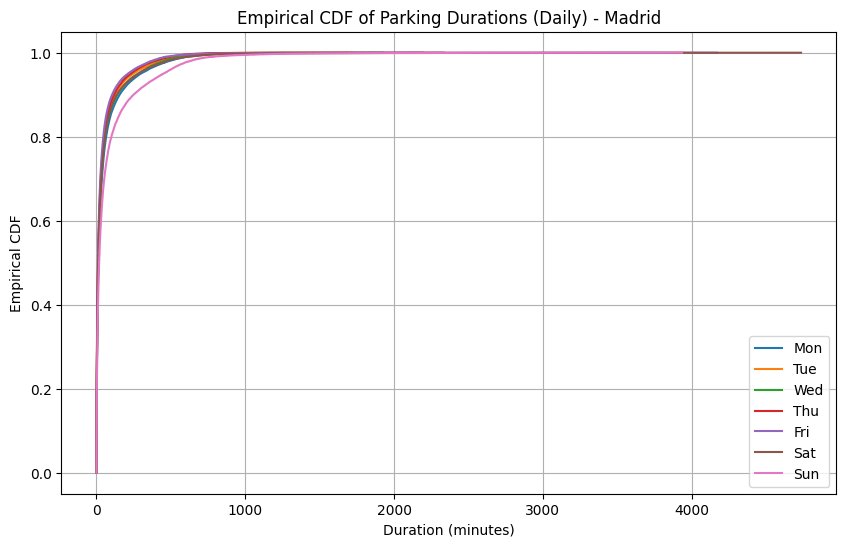

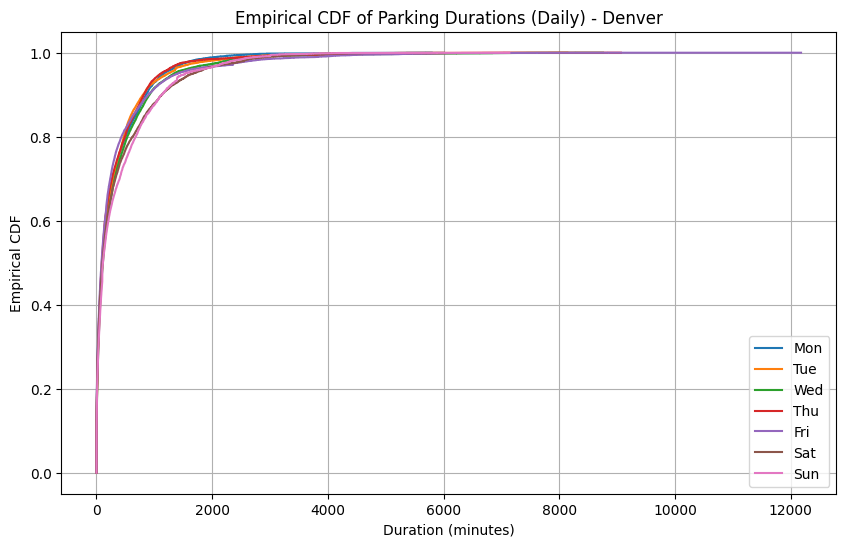

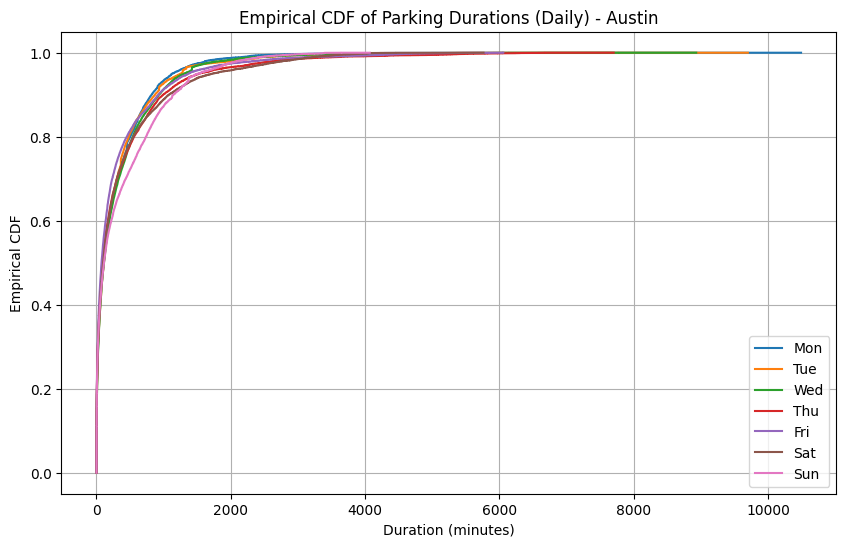

In [14]:
def get_daily_durations(collection, city):
    """Retrieve durations by day of the week for a specific city."""
    daily_durations = {day: [] for day in range(7)}  # 0=Monday, ..., 6=Sunday
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lt': end_date},
        'final_date': {'$exists': True}
    }
    # Retrieve data and calculate durations
    data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
    df = pd.DataFrame(data)
    if not df.empty:
        df['init_date'] = pd.to_datetime(df['init_date'])
        df['final_date'] = pd.to_datetime(df['final_date'])
        df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
        df = df[df['duration'] > 0]
        df['day_of_week'] = df['init_date'].dt.dayofweek  # 0=Monday, ..., 6=Sunday
        for day in range(7):
            daily_durations[day] = df[df['day_of_week'] == day]['duration']
    return daily_durations

# Plot daily CDFs for each city
for city in cities:
    daily_durations = get_daily_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for day, durations in daily_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day])
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(f'Empirical CDF of Parking Durations (Daily) - {city}')
    plt.legend()
    plt.grid(True)
    plt.show()


Madrid: The daily CDFs for Madrid are very similar, with only minor differences across the days. This suggests that parking duration patterns are relatively consistent throughout the week.
Slight Variation on Sundays: Sundays show a slightly slower rise in the CDF, indicating that parking durations might be marginally longer on this day. This could be due to less frequent car usage or extended parking durations for weekend activities.
Overall, the CDFs suggest stable parking behavior in Madrid, with only minor variations between weekdays and weekends.
Denver:

Denver's daily CDFs show a bit more variation than Madrid’s, especially on the weekends (Saturday and Sunday).
Longer Parking Durations on Weekends: The slower rise in the CDF on weekends (especially Sunday) suggests that cars are left parked for longer durations compared to weekdays. This pattern may reflect reduced weekday commuting and an increase in longer leisure-related parking.
The weekday CDFs are relatively consistent, indicating that weekday parking patterns in Denver are stable and likely driven by regular commuting behavior.
Austin:

Austin displays a pattern similar to Denver, where the weekend (especially Sunday) shows a slower rise in the CDF, suggesting longer parking durations.
Weekday vs. Weekend Differences: Like Denver, Austin shows a consistent pattern on weekdays, with shorter parking durations. Weekend usage seems to involve longer parkings, which might reflect lower turnover or less frequent use.
The weekday CDFs in Austin are almost identical, implying that users have consistent parking durations on these days.
General Observations Across Cities
Consistent Weekday Patterns: For all three cities, weekday CDFs are fairly consistent, indicating that parking behavior on weekdays is likely driven by predictable commuting patterns.
Longer Parking Durations on Weekends: In both Denver and Austin, and to a lesser extent in Madrid, weekends show longer parking durations. This may reflect a shift toward leisure activities, where cars are left parked for extended periods, possibly overnight or for full-day events.
Summary of Findings
Stable Weekday Parking: Weekday parking patterns are consistent across all cities, suggesting they are influenced by regular work or commuting schedules.
Weekend Differences: Weekends, especially Sundays, show longer parking durations, particularly in Denver and Austin. This is likely due to leisure activities and reduced vehicle turnover.
City-Specific Behavior: Madrid shows minimal day-to-day variation, indicating a relatively stable usage pattern throughout the week, while Denver and Austin display more distinct weekend behavior.

## Question 2

### Code

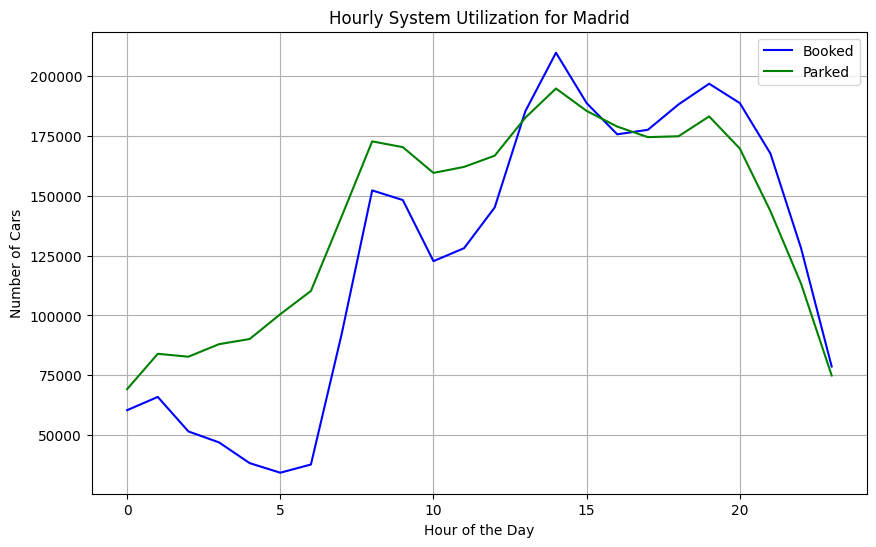

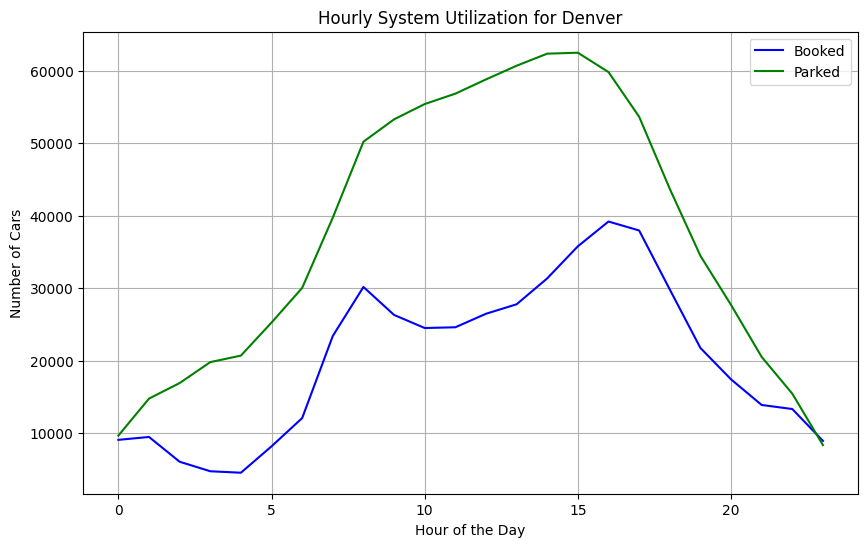

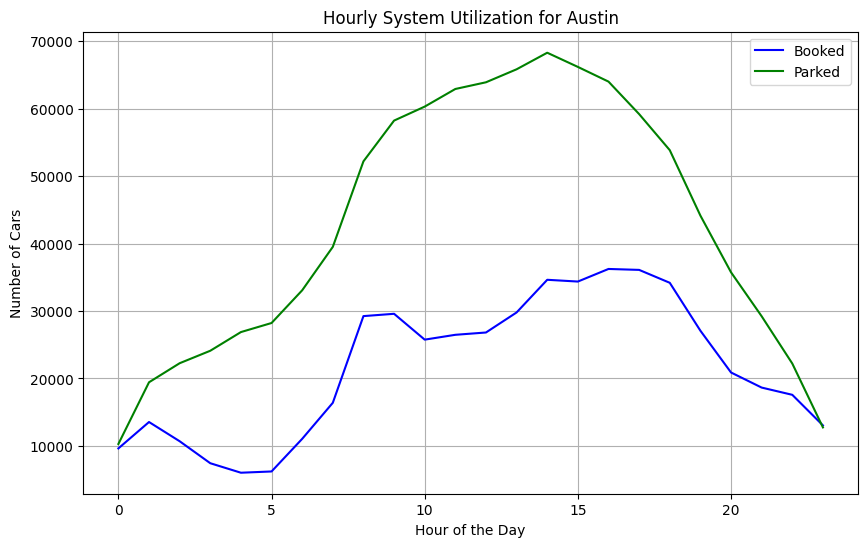

In [15]:
# Function to aggregate bookings/parkings per hour
def get_hourly_utilization(collection, city, status_field):
    """Aggregates the count of booked/parked cars per hour of the day for a specific city."""
    # Query to filter by city and by whether the car is booked/parked
    query = {'city': city}
    projection = {
        '_id': 0,
        'init_date': 1,
        'final_date': 1
    }

    # Retrieve data
    data = list(collection.find(query, projection))
    df = pd.DataFrame(data)
    
    # Filter out any rows with missing dates
    df = df.dropna(subset=['init_date', 'final_date'])

    # Convert to datetime
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])

    # Create an empty dataframe to track counts per hour
    hourly_counts = pd.DataFrame(0, index=range(24), columns=['count'])

    # Iterate through each booking/parking to increment hourly counts
    for _, row in df.iterrows():
        start_hour = row['init_date'].hour
        end_hour = row['final_date'].hour
        
        # Increment the count for each hour within the booking/parking period
        for hour in range(start_hour, end_hour + 1):
            if hour in hourly_counts.index:
                hourly_counts.loc[hour, 'count'] += 1

    return hourly_counts

# Get utilization data for each city for booked and parked cars
cities = ['Madrid', 'Denver', 'Austin']
for city in cities:
    # Get hourly booked and parked counts
    booked_hourly = get_hourly_utilization(bookings_collection, city, 'booked')
    parked_hourly = get_hourly_utilization(parkings_collection, city, 'parked')

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(booked_hourly.index, booked_hourly['count'], label='Booked', color='blue')
    plt.plot(parked_hourly.index, parked_hourly['count'], label='Parked', color='green')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Hourly System Utilization for {city}')
    plt.legend()
    plt.grid()
    plt.show()

### Interpretation

1. General Patterns Across Cities
Across all three cities, we observe a similar daily usage pattern:

Early Morning (0–6 AM): Low activity, with most cars parked and a minimal number of bookings.
Morning Rise (6–10 AM): A sharp increase in bookings as people begin their daily activities, likely commuting to work or running morning errands. This corresponds with a decrease in parked cars.
Midday Plateau (10 AM–4 PM): The number of booked cars remains relatively stable, with slight fluctuations, while the number of parked cars remains lower.
Evening Peak (4–7 PM): Another increase in bookings, likely due to people commuting home or engaging in evening activities.
Late Evening (7–10 PM): A decline in bookings and an increase in parked cars as people conclude their activities and cars remain parked overnight.
2. City-Specific Observations
Madrid
Booking Peak: Madrid shows a distinct peak in bookings around 9 AM and a secondary peak around 5 PM.
Parked Cars: The number of parked cars drops sharply in the morning but rises again in the early evening, peaking around 6 PM.
Outliers: There appears to be a slight dip in parked cars around 4 PM, which could indicate a spike in usage for evening activities. The early morning hours (1-4 AM) also have a slight variation in parked cars, which might be due to night-time maintenance or unexpected user activity.
Denver
Booking Peak: Bookings in Denver gradually rise through the morning and peak around 3–4 PM, slightly later than in Madrid.
Parked Cars: The parked cars follow a complementary pattern, decreasing as bookings rise and peaking at night.
Outliers: The patterns are smooth, but there’s a visible drop in parked cars around 4 PM, followed by a gradual increase, suggesting high afternoon demand. Denver's utilization pattern indicates relatively consistent use throughout the day, with fewer dramatic peaks than in Madrid.
Austin
Booking Peak: Austin displays a consistent booking pattern similar to Denver, with a peak in the late afternoon around 3–4 PM.
Parked Cars: The parked cars decrease sharply in the morning and stay lower through the day, peaking at night.
Outliers: Austin’s pattern is also smooth, but it shows a higher proportion of parked cars in the early hours, possibly indicating overnight or long-duration parking. The relatively high number of parked cars throughout the early afternoon might suggest less turnover compared to Madrid.

3. Interpretation of Outliers
Midday and Afternoon Peaks: In Madrid, there’s a noticeable midday usage peak, which could be due to cultural differences, such as midday errands or lunch breaks leading to increased usage.
Late Afternoon and Evening Spikes: All cities show higher booking counts in the late afternoon, aligning with typical commuting patterns.
Nighttime Stability: Across all cities, parked cars peak at night, as expected when most people are not actively using car-sharing services.
Possible Explanations for Outliers
Local Events or Commute Patterns: The midday peak in Madrid could reflect cultural factors or local events. In contrast, Denver and Austin show smoother midday usage, likely driven by a more uniform workday pattern.
Service Characteristics: High parked car counts at night across all cities may indicate downtime or non-active hours for the fleet, typical of car-sharing services.
Maintenance or Operational Factors: Unusual dips in parked cars in early morning or late night hours might be due to fleet maintenance or cleaning schedules that temporarily take cars out of availability.
Summary
Peak Times: All cities show peak utilization during commuting hours, with minor differences in the exact peak times.
Outliers: The afternoon and late-night patterns might reflect external factors like cultural habits, local events, or operational practices.
Potential Adjustments: Understanding these hourly patterns could help optimize fleet distribution, maintenance scheduling, and promotional activities during off-peak hours.

## Question 3


To filter out potential outliers in booking durations (such as bookings that are unrealistically short or excessively long), we can establish a set of criteria based on statistical and logical thresholds. This filtering will help us retain only plausible rentals and exclude bookings that likely indicate system issues, data collection errors, or unusual usage.

Criteria to Filter Outliers in Booking Durations
Minimum and Maximum Thresholds Based on Business Logic:

Minimum Booking Duration: Define a lower limit for booking duration based on the expected minimum time required for a valid rental. For example:
Short rentals (e.g., less than 2-5 minutes) may indicate erroneous or accidental bookings.
Set a threshold such as > 2 minutes to exclude bookings that are implausibly short.
Maximum Booking Duration: Define an upper limit based on what is considered a reasonable maximum rental time for car-sharing services.
For example, rentals over 24 hours (1440 minutes) could be considered suspicious, as most car-sharing rentals are intended for shorter durations. However, this threshold might vary by service model and can be adjusted as needed.
Set an upper threshold, such as < 1440 minutes (or another appropriate value based on business insights) to exclude abnormally long bookings that are likely outliers.
Statistical Thresholds Using the Interquartile Range (IQR):

Use the Interquartile Range (IQR) to detect extreme values in booking durations.
Compute the 25th percentile (Q1) and 75th percentile (Q3) of the booking durations and calculate the IQR as IQR=Q3−Q1.
Define lower and upper bounds as:
Lower Bound:Q1−1.5×IQR
Upper Bound: 𝑄3+1.5×IQR
Any booking duration outside this range can be flagged as an outlier.
Additional Filters for Specific Patterns or Anomalies:

Overlapping Bookings: Identify and filter out cases where the same car is booked by multiple users simultaneously, which might indicate data duplication or a system error.
High Frequency of Bookings: If a specific car has a high number of extremely short bookings in a short time frame, it might indicate a system issue or test data.

## Question 4


### Code

In [5]:
# Queries for filtered data
filtered_query = {
    "city": {"$in": cities},
    "init_date": {"$gte": start_date, "$lte": end_date},
    "final_date": {"$exists": True}  # Ensures final_date exists
}

# Load unfiltered data
df_bookings_unfiltered = pd.DataFrame(list(db['PermanentBookings'].find(filtered_query)))
df_parkings_unfiltered = pd.DataFrame(list(db['PermanentParkings'].find(filtered_query)))

# Ensure init_date and final_date are in datetime format
df_bookings_unfiltered['init_date'] = pd.to_datetime(df_bookings_unfiltered['init_date'])
df_bookings_unfiltered['final_date'] = pd.to_datetime(df_bookings_unfiltered['final_date'])
df_parkings_unfiltered['init_date'] = pd.to_datetime(df_parkings_unfiltered['init_date'])
df_parkings_unfiltered['final_date'] = pd.to_datetime(df_parkings_unfiltered['final_date'])

# Calculate duration in minutes for both bookings and parkings
df_bookings_unfiltered['duration'] = (df_bookings_unfiltered['final_date'] - df_bookings_unfiltered['init_date']).dt.total_seconds() / 60
df_parkings_unfiltered['duration'] = (df_parkings_unfiltered['final_date'] - df_parkings_unfiltered['init_date']).dt.total_seconds() / 60

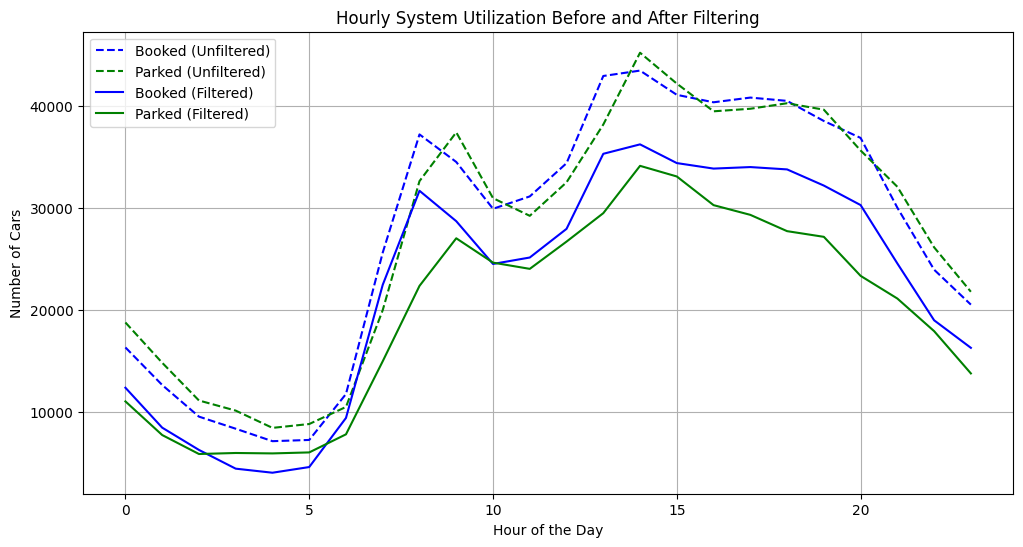

In [8]:
# Define logical duration thresholds
MIN_DURATION = 2      # Minimum plausible duration in minutes
MAX_DURATION = 1440   # Maximum plausible duration in minutes (24 hours)

def filter_data(df):
    # Apply logical thresholds
    df_filtered = df[(df['duration'] > MIN_DURATION) & (df['duration'] < MAX_DURATION)]
    
    # Calculate IQR
    Q1 = df_filtered['duration'].quantile(0.25)
    Q3 = df_filtered['duration'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply IQR-based filtering
    df_filtered = df_filtered[(df_filtered['duration'] >= lower_bound) & (df_filtered['duration'] <= upper_bound)]
    return df_filtered

# Filter bookings and parkings
df_bookings_filtered = filter_data(df_bookings_unfiltered)
df_parkings_filtered = filter_data(df_parkings_unfiltered)


# Function to calculate hourly utilization
def calculate_hourly_utilization(df):
    df['hour'] = df['init_date'].dt.hour  # Extract hour
    hourly_utilization = df.groupby('hour').size()  # Count occurrences per hour
    return hourly_utilization.reindex(range(24), fill_value=0)  # Ensure all hours are included

# Unfiltered utilization
booked_hourly_unfiltered = calculate_hourly_utilization(df_bookings_unfiltered)
parked_hourly_unfiltered = calculate_hourly_utilization(df_parkings_unfiltered)

# Filtered utilization
booked_hourly_filtered = calculate_hourly_utilization(df_bookings_filtered)
parked_hourly_filtered = calculate_hourly_utilization(df_parkings_filtered)


import matplotlib.pyplot as plt

hours = range(24)

# Plot unfiltered utilization
plt.figure(figsize=(12, 6))
plt.plot(hours, booked_hourly_unfiltered, label='Booked (Unfiltered)', color='blue', linestyle='--')
plt.plot(hours, parked_hourly_unfiltered, label='Parked (Unfiltered)', color='green', linestyle='--')

# Plot filtered utilization
plt.plot(hours, booked_hourly_filtered, label='Booked (Filtered)', color='blue')
plt.plot(hours, parked_hourly_filtered, label='Parked (Filtered)', color='green')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Cars')
plt.title('Hourly System Utilization Before and After Filtering')
plt.legend()
plt.grid()
plt.show()



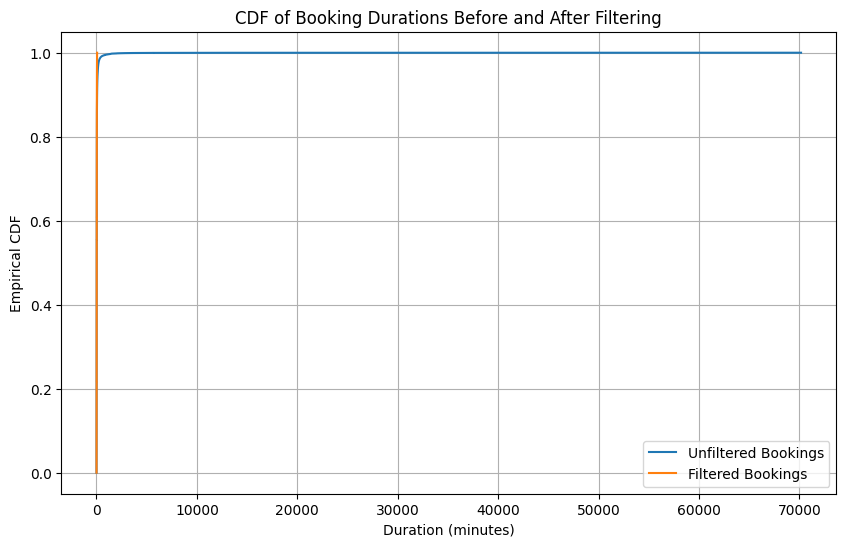

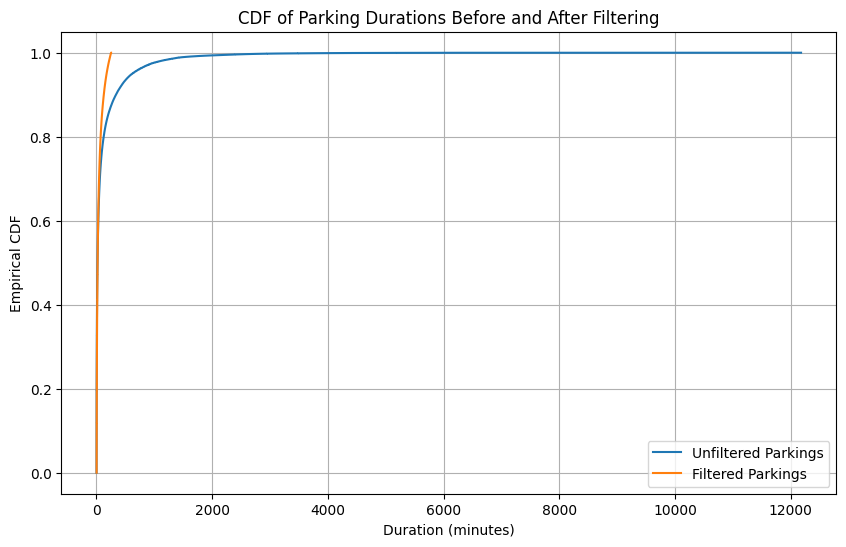

In [9]:
import numpy as np

def plot_cdf(data, title, label):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / float(len(sorted_data))
    plt.step(sorted_data, yvals, label=label)
    
# Plot CDFs for bookings
plt.figure(figsize=(10, 6))
plot_cdf(df_bookings_unfiltered['duration'], 'CDF of Booking Durations', 'Unfiltered Bookings')
plot_cdf(df_bookings_filtered['duration'], 'CDF of Booking Durations', 'Filtered Bookings')
plt.xlabel('Duration (minutes)')
plt.ylabel('Empirical CDF')
plt.title('CDF of Booking Durations Before and After Filtering')
plt.legend()
plt.grid()
plt.show()

# Plot CDFs for parkings
plt.figure(figsize=(10, 6))
plot_cdf(df_parkings_unfiltered['duration'], 'CDF of Parking Durations', 'Unfiltered Parkings')
plot_cdf(df_parkings_filtered['duration'], 'CDF of Parking Durations', 'Filtered Parkings')
plt.xlabel('Duration (minutes)')
plt.ylabel('Empirical CDF')
plt.title('CDF of Parking Durations Before and After Filtering')
plt.legend()
plt.grid()
plt.show()


Unfiltered CDFs:

In both the booking and parking duration CDFs, the unfiltered data shows a long tail extending to very high durations (up to 70,000 minutes for bookings and 12,000 minutes for parkings). This suggests that there are some extremely long-duration events, likely representing outliers or unusual cases.
The rapid initial rise of the unfiltered CDFs to nearly 1.0 indicates that the vast majority of events are of shorter durations, while a few outliers stretch the data to extremely high values.
Filtered CDFs:

After filtering, the CDFs for both bookings and parkings show a sharp leftward shift, with the longest durations significantly reduced.
The filtered data cuts off at a much lower duration, indicating that outliers (such as extremely long bookings and parkings) have been effectively removed. The booking durations are now capped closer to a reasonable maximum (for example, within a range that aligns more with typical car-sharing usage).
The initial rapid rise in the CDF is now more prominent, highlighting that most bookings and parkings fall within a shorter, more realistic range.
Impact of Filtering:

Reduction of Outliers: The filtering process appears to have successfully removed extreme outliers. The long tail of high-duration events is largely eliminated, allowing the CDF to represent a more typical distribution of booking and parking durations.
Clearer Distribution: The filtered CDFs give a clearer view of typical user behavior, as they emphasize the high density of short-duration events and exclude implausibly long durations that could distort analysis.
Better Alignment with Expected Behavior: The filtered data now represents a more realistic spread of booking and parking durations, better aligning with typical usage patterns expected in car-sharing services.
Summary
Effectiveness of Filtering: The filtering approach effectively removes extreme outliers, as evidenced by the cutoff in the filtered CDFs. This helps in focusing on typical user behavior rather than on anomalous data points.
Comparison of Distributions: The filtered CDFs provide a more compact and interpretable distribution, allowing for a better understanding of the most common booking and parking durations.
Implications: With outliers removed, analysis of system utilization over time will now more accurately reflect actual demand, avoiding distortions from unusual cases.

## Question 5

### Code

In [10]:
# Calculate daily statistics for a given DataFrame
def compute_daily_statistics(df):
    # Extract date (ignoring time)
    df['date'] = df['init_date'].dt.date
    
    # Group by date and compute statistics
    daily_stats = df.groupby('date')['duration'].agg(
        average='mean',
        median='median',
        std_dev='std',
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.5),
        p75=lambda x: x.quantile(0.75)
    ).reset_index()
    
    return daily_stats

# Compute statistics for bookings and parkings
daily_stats_bookings = compute_daily_statistics(df_bookings_filtered)
daily_stats_parkings = compute_daily_statistics(df_parkings_filtered)

# Display the statistics for the first few days to verify
print("Daily Statistics for Bookings:")
print(daily_stats_bookings.head())

print("Daily Statistics for Parkings:")
print(daily_stats_parkings.head())


Daily Statistics for Bookings:
         date    average     median    std_dev        p25        p50  \
0  2017-11-01  23.022980  21.483333  11.666227  14.708333  21.483333   
1  2017-11-02  22.531600  20.891667  10.814767  15.170833  20.891667   
2  2017-11-13  22.205642  20.733333  11.457441  13.866667  20.733333   
3  2017-11-14  23.090000  21.083333  11.826945  14.945833  21.083333   
4  2017-11-15  22.904296  20.916667  12.131865  14.204167  20.916667   

         p75  
0  29.933333  
1  28.166667  
2  29.183333  
3  30.016667  
4  29.933333  
Daily Statistics for Parkings:
         date    average     median    std_dev       p25        p50        p75
0  2017-11-01  48.742012  23.450000  58.527287  8.100000  23.450000  66.004167
1  2017-11-02  45.446754  20.400000  57.664730  7.916667  20.400000  57.591667
2  2017-11-13  47.464919  22.916667  56.765796  8.100000  22.916667  63.612500
3  2017-11-14  44.643455  20.166667  56.057606  7.150000  20.166667  58.600000
4  2017-11-15  45.54

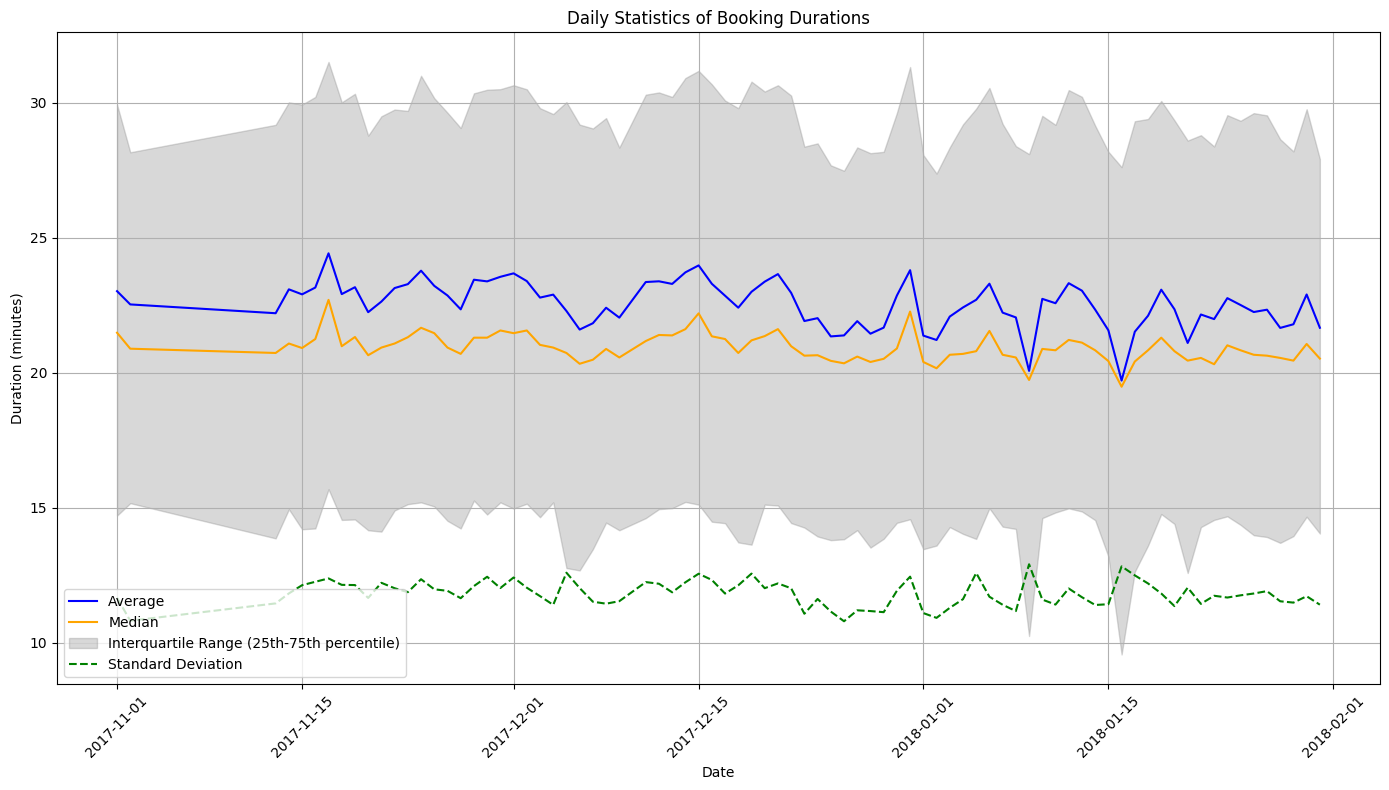

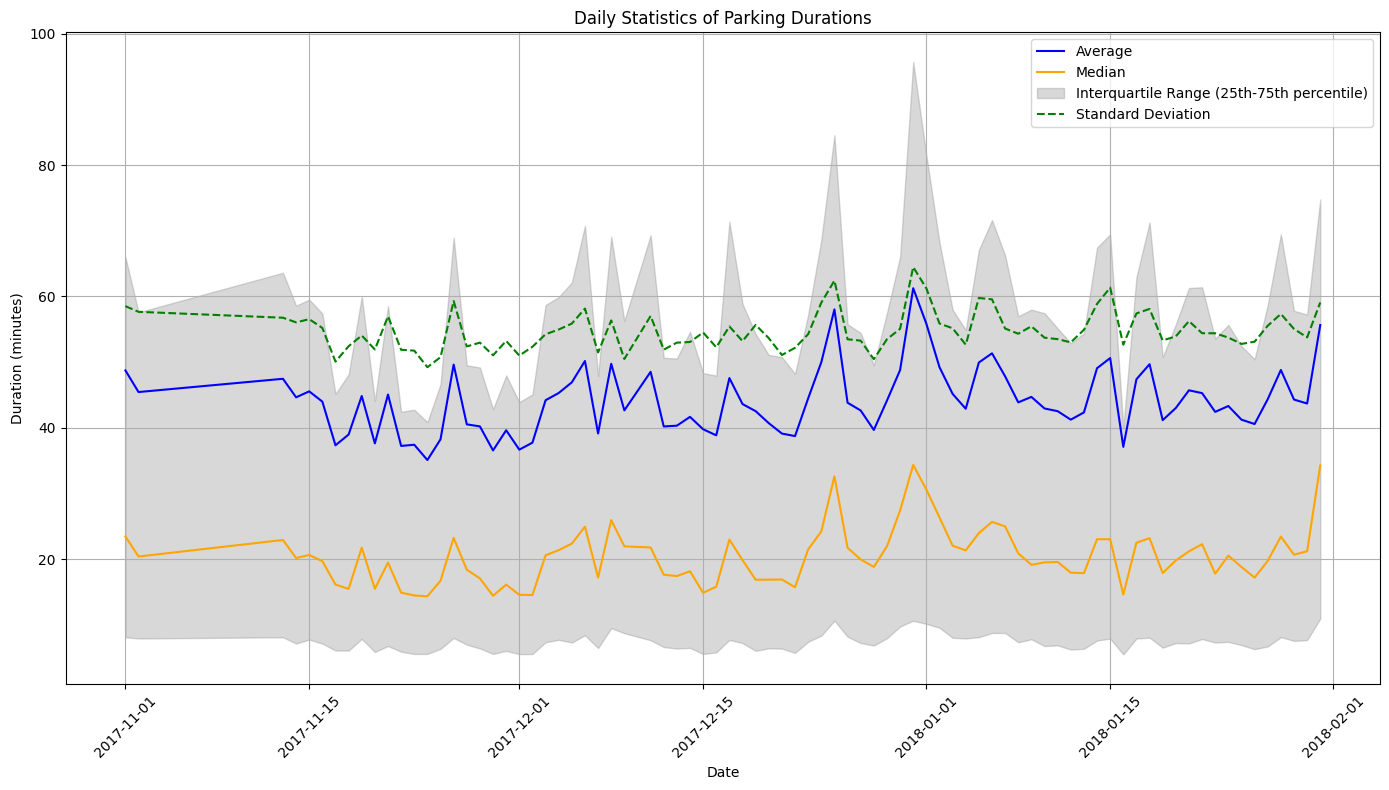

In [11]:
import matplotlib.pyplot as plt

def plot_daily_statistics(daily_stats, title):
    plt.figure(figsize=(14, 8))
    
    plt.plot(daily_stats['date'], daily_stats['average'], label='Average', color='blue')
    plt.plot(daily_stats['date'], daily_stats['median'], label='Median', color='orange')
    plt.fill_between(daily_stats['date'], daily_stats['p25'], daily_stats['p75'], color='grey', alpha=0.3, label='Interquartile Range (25th-75th percentile)')
    plt.plot(daily_stats['date'], daily_stats['std_dev'], label='Standard Deviation', color='green', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Duration (minutes)')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot statistics for bookings and parkings
plot_daily_statistics(daily_stats_bookings, 'Daily Statistics of Booking Durations')
plot_daily_statistics(daily_stats_parkings, 'Daily Statistics of Parking Durations')


### Interpretation

#### Analysis of Daily Statistics for Booking Durations

1. **Average and Median**:
   - The average booking duration fluctuates around 22–25 minutes, while the median duration is slightly lower, around 18–22 minutes.
   - This gap between the average and median suggests some skew in the data, likely due to a few longer bookings that push up the average relative to the median.

2. **Interquartile Range (IQR)**:
   - The IQR (the shaded region) shows the spread of durations between the 25th and 75th percentiles.
   - The IQR appears fairly stable with minor fluctuations, indicating that the middle 50% of bookings remain consistent over time.
   - Some minor fluctuations in the IQR, particularly in mid-November and early January, might indicate days with slightly longer or shorter bookings.

3. **Standard Deviation**:
   - The standard deviation line (dashed green) shows some variability but generally stays within a 10–15 minute range.
   - Peaks in standard deviation might indicate days with a wider range of booking durations, potentially influenced by unusual events or varying user behavior on those days.

4. **Observations**:
   - **Periodicity**: There doesn’t appear to be a strong periodic trend (e.g., weekends vs. weekdays) in the average or median values. However, minor weekly fluctuations might exist, although they are subtle in the plot.
   - **Trend**: No significant upward or downward trend is evident, suggesting that booking durations remain consistent over this time period.
   - **Holidays and Events**: Around late December, there’s a slight increase in the average and IQR, possibly indicating holiday-related bookings that tend to be longer.

#### Analysis of Daily Statistics for Parking Durations

1. **Average and Median**:
   - The average parking duration fluctuates around 40–60 minutes, while the median is lower, around 15–25 minutes.
   - The larger difference between the average and median in parkings compared to bookings suggests more pronounced skew, indicating the presence of longer parking durations.

2. **Interquartile Range (IQR)**:
   - The IQR for parking durations is much wider and more variable than for bookings, indicating that parking durations have more variability.
   - Several peaks and valleys in the IQR suggest periods with higher or lower parking duration variability. For instance, mid-December and early January show increased IQRs, possibly reflecting more variable parking behavior during holidays.

3. **Standard Deviation**:
   - The standard deviation (dashed green) is higher for parking durations, often around 30–40 minutes, and shows greater fluctuations compared to bookings.
   - This higher variability might indicate that users park for widely varying lengths of time, potentially influenced by different types of activities.

4. **Observations**:
   - **Periodicity**: There seems to be some recurring patterns in the IQR and standard deviation of parking durations, potentially reflecting weekend vs. weekday differences where parking durations might vary depending on activity types (e.g., work vs. leisure).
   - **Trend**: While no clear upward or downward trend is observed, peaks in parking durations around December and January might correspond to holiday or event periods where users park for longer durations.
   - **Holiday Impact**: The spikes in average and IQR around mid-December and early January could indicate holiday effects, where users might park for extended periods.

### Summary of Findings

1. **Fluctuations Over Time**: Both bookings and parkings show some day-to-day fluctuations, though bookings are generally more stable in terms of duration. Parking durations have higher variability, suggesting different patterns of use.

2. **Periodicity**:
   - Minor periodicity might exist in parking durations, possibly reflecting weekend vs. weekday differences. However, booking durations are relatively stable and do not show strong periodic patterns.
   - Further examination of specific days (like weekends vs. weekdays) could clarify these observations.

3. **Holiday and Seasonal Effects**:
   - Around the holiday season (December and January), both booking and parking durations show increased variability and slightly higher average durations, likely reflecting changes in user behavior during these periods.

4. **Consistency of Trends**:
   - There’s no clear long-term increasing or decreasing trend in either bookings or parkings, suggesting that overall usage patterns are stable over the period observed.


### Question 6


Use the MongoDB query to filter valid rentals in Milano where data for public transport is available (assuming such data is in the same or a related collection). Extract the duration of rentals and public transport.

In [ ]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://bidgatadb.polito.it:27017")
db = client['YourDatabaseName']

# Query for rentals in Milano with valid public transport data
rentals_with_transport_query = {
    "city": "Milano",
    "public_transport.duration": {"$gte": 0},  # Ensure public transport data exists
}
df_rentals = pd.DataFrame(list(db['PermanentBookings'].find(rentals_with_transport_query)))

# Extract required fields
df_rentals['rental_duration'] = (df_rentals['final_date'] - df_rentals['init_date']).dt.total_seconds() / 60
df_rentals['public_transport_duration'] = df_rentals['public_transport'].apply(lambda x: x['duration'])


Create Bins: Divide the public_transport_duration into intervals (e.g., [0, 5), [5, 10), etc.).

Compute Probabilities: Count the number of rentals for each bin and compute the probability using Bayes' theorem:

𝑃
(
Rental
∣
Transport Duration in Bin
)
=
P(Rental∣Transport Duration in Bin)= 
𝑃
(
Transport Duration in Bin
∣
Rental
)
𝑃
(
Rental
)
/
𝑃
(
Transport Duration in Bin
)
P(Transport Duration in Bin∣Rental)P(Rental)/P(Transport Duration in Bin)

In [ ]:
import numpy as np

# Create time bins for public transport duration
bins = np.arange(0, df_rentals['public_transport_duration'].max() + 5, 5)
df_rentals['duration_bin'] = pd.cut(df_rentals['public_transport_duration'], bins=bins, right=False)

# Calculate probabilities for each bin
bin_counts = df_rentals['duration_bin'].value_counts().sort_index()
prob_rental_given_bin = bin_counts / bin_counts.sum()  # Simplified without explicit Bayes adjustment

# Plot the histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(prob_rental_given_bin.index.astype(str), prob_rental_given_bin.values, width=0.8)
plt.xlabel("Public Transport Duration (Minutes)")
plt.ylabel("Probability of Rental")
plt.title("Probability of Rental Given Public Transport Duration")
plt.xticks(rotation=45)
plt.grid()
plt.show()


Shorter public transport durations might correspond to higher rental probabilities, indicating rentals are more likely for shorter public transport trips (e.g., last-mile trips).
Longer transport durations might correlate with lower rental probabilities, reflecting competition with more efficient public transport for longer trips.

### Question 7

Extract and Filter Data: Extract the positions of cars (origin for booking and destination for return) during specified hours.
python
Copy code


In [ ]:
from datetime import datetime

# Filter rentals for Milano with spatial data
rental_positions_query = {
    "city": "Milano",
    "init_date": {"$gte": datetime(2017, 11, 1), "$lte": datetime(2018, 1, 31)},
    "origin_destination.coordinates": {"$exists": True}
}
df_positions = pd.DataFrame(list(db['PermanentBookings'].find(rental_positions_query)))

# Extract origin and destination coordinates
df_positions['origin'] = df_positions['origin_destination'].apply(lambda x: x['coordinates'][0])
df_positions['destination'] = df_positions['origin_destination'].apply(lambda x: x['coordinates'][1])
df_positions['hour'] = df_positions['init_date'].dt.hour


Plot on Map: Use a mapping library like folium to plot origins and destinations at specific times.

In [ ]:
import folium

# Function to plot coordinates on a map
def plot_on_map(df, col, title):
    m = folium.Map(location=[45.4642, 9.1900], zoom_start=12)  # Centered on Milan
    for _, row in df.iterrows():
        folium.CircleMarker(location=row[col], radius=2, color="blue").add_to(m)
    return m

# Filter by time ranges (e.g., Monday 8-10)
monday_8_10 = df_positions[(df_positions['init_date'].dt.weekday == 0) & (df_positions['hour'].between(8, 10))]
monday_map = plot_on_map(monday_8_10, 'origin', 'Car Positions: Monday 8-10')
monday_map.save("monday_8_10_map.html")


Divide Milan into a grid of zones (e.g., latitude/longitude bins) and compute the density of car origins and destinations in each zone.

In [ ]:
# Define grid bins for Milan
lat_bins = np.linspace(df_positions['origin'].apply(lambda x: x[1]).min(),
                       df_positions['origin'].apply(lambda x: x[1]).max(), 20)
lon_bins = np.linspace(df_positions['origin'].apply(lambda x: x[0]).min(),
                       df_positions['origin'].apply(lambda x: x[0]).max(), 20)

# Compute density for origins
df_positions['lat_bin'] = pd.cut(df_positions['origin'].apply(lambda x: x[1]), bins=lat_bins)
df_positions['lon_bin'] = pd.cut(df_positions['origin'].apply(lambda x: x[0]), bins=lon_bins)
density = df_positions.groupby(['lat_bin', 'lon_bin']).size().unstack(fill_value=0)

# Plot heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(density, cmap='coolwarm')
plt.title("Origin Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


c. Compare Destination Zones for Different Times
To compare:

Filter data for specific time ranges (e.g., 8-10 and 18-20).
Generate separate density maps or heatmaps for each range.
Compare differences in density visually or compute statistical differences.

In [ ]:
# Filter by time ranges and compute densities
evening = df_positions[df_positions['hour'].between(18, 20)]
morning_density = morning.groupby(['lat_bin', 'lon_bin']).size().unstack(fill_value=0)
evening_density = evening.groupby(['lat_bin', 'lon_bin']).size().unstack(fill_value=0)

# Plot heatmaps for comparison
plt.figure(figsize=(10, 8))
sns.heatmap(morning_density, cmap='coolwarm')
plt.title("Morning (8-10) Destination Density")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(evening_density, cmap='coolwarm')
plt.title("Evening (18-20) Destination Density")
plt.show()


Insights:
Different Times: Morning destinations may cluster around work zones, while evening destinations might focus on residential areas.
Weekends vs. Weekdays: Weekends might show more leisure-related clusters (e.g., parks, shopping areas), while weekdays center around work zones.
Heatmap Comparison: Use the heatmaps to understand shifts in demand and plan resource allocation effectively.